In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tabulate import tabulate

In [5]:
mpl.rcdefaults()

In [6]:
mpl.rcParams['figure.dpi'] = 300

In [9]:
models = [
    #'simplemodel-bce-w-128-e-100-b-32',
    'stgnn-bce-gru-1-gcn-1-h-64-o-128-w-128-e-100-b-32',
    'stgnn-bce-lstm-1-gcn-1-h-64-o-128-w-128-e-100-b-32',
    'stgnn-bce-cnn-1-gcn-1-h-64-o-128-w-128-e-30-b-32'
]
model_names = {
    'simplemodel-bce-w-128-e-100-b-32':'simplemodel',
    'stgnn-bce-gru-1-gcn-1-h-64-o-128-w-128-e-100-b-32':'gru-gcn',
    'stgnn-bce-lstm-1-gcn-1-h-64-o-128-w-128-e-100-b-32':'lstm-gcn',
    'stgnn-bce-cnn-1-gcn-1-h-64-o-128-w-128-e-30-b-32':'cnn-gcn'
}
metrics = ['loss', 'accuracy', 'f1']
log_dir = 'logs'
sns.set_style("whitegrid")
paired_colors = sns.color_palette("Paired", n_colors=2 * len(models))
model_colors = {model_names[model]: (paired_colors[i * 2], paired_colors[i * 2 + 1]) for i, model in enumerate(models)}

In [13]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

column_width = 426.0  # Column width (pt) in LaTeX
fig_size = get_figsize(column_width, wf=0.6, hf=1.0)

def plot_metrics(metrics, model_metrics_df, dataset, save=False, max_epoch=None):
    
    for metric in metrics:
        plt.figure(figsize=fig_size)  # Create a new figure for each metric
        
        for model_name, df in model_metrics_df.items():
            train_metric = df[f"train_{metric}"].dropna().reset_index(drop=True)
            val_metric = df[f"val_{metric}"].dropna().reset_index(drop=True)
            epochs = df["epoch"].drop_duplicates().reset_index(drop=True)
            max_epoch = len(epochs) if max_epoch is None else max_epoch
            sns.lineplot(x=epochs[:max_epoch], y=train_metric[:max_epoch], label=f"{model_name} train", linestyle="solid", color=model_colors[model_name][0])
            # Plot validation metric
            sns.lineplot(x=epochs[:max_epoch], y=val_metric[:max_epoch], label=f"{model_name} val", linestyle="dashed", color=model_colors[model_name][1])
    
        #plt.title(f"{metric.capitalize()}", fontsize=14)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        #plt.ylabel('')
        plt.legend()
        plt.tight_layout()
        if save:
            plt.savefig(f'trainfig/{dataset}_{metric}.pdf', format='pdf')
        plt.show()  # Show each figure separately
        
def print_test_metrics_table(model_metrics):
    """
    Prints a table of test metrics for each model.
    
    Parameters:
        model_metrics (dict): Dictionary where keys are model names and 
                              values are dataframes with test metrics.
    """
    # Extract the last row (final test metrics) for each model
    table_data = []
    for model_name, df in model_metrics.items():
        final_metrics = df.iloc[-1][["test_loss", "test_accuracy", "test_f1", "test_precision", "test_recall"]].values
        table_data.append([model_name] + list(final_metrics))

    # Define table headers
    headers = ["Model", "Test Loss", "Test Accuracy", "Test F1", "Test Precision", "Test Recall"]

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))

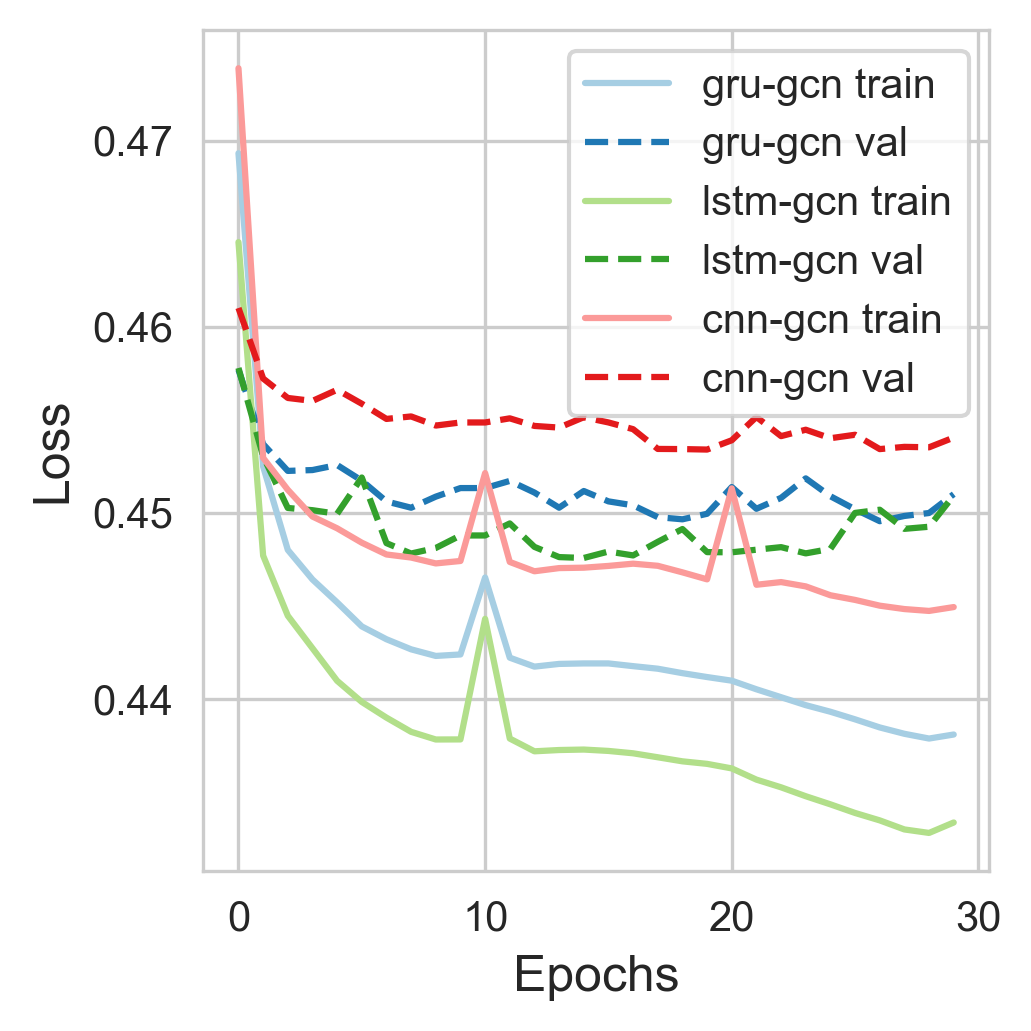

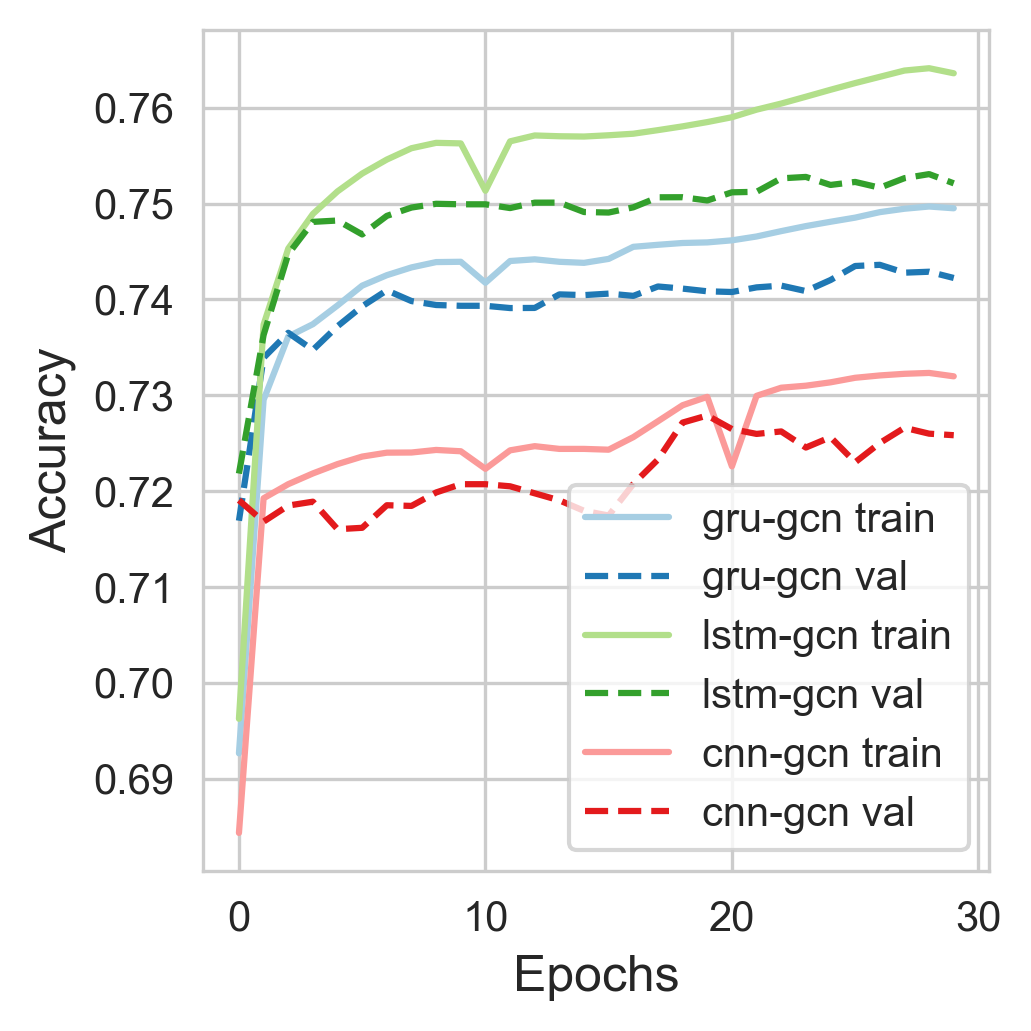

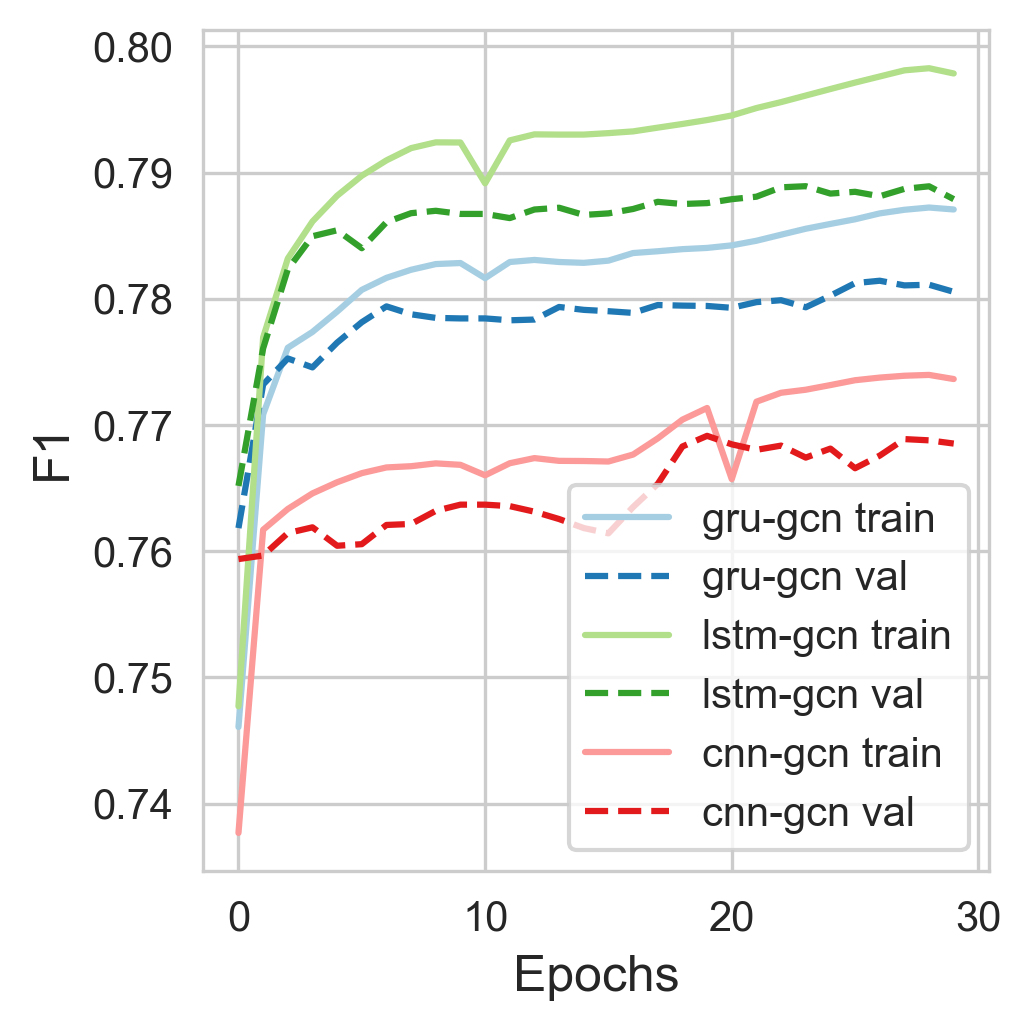

In [14]:
dataset = 'satcon'
paths = {model:f'{log_dir}/{model}/version_1/metrics.csv' for model in models}
model_metrics= {model_names[model]: pd.read_csv(path) for model, path in paths.items()}
plot_metrics(metrics, model_metrics, dataset, save=True, max_epoch=30)

In [8]:
print_test_metrics_table(model_metrics)

KeyError: "None of [Index(['test_loss', 'test_accuracy', 'test_f1', 'test_precision',\n       'test_recall'],\n      dtype='object')] are in the [index]"

Plotting Training Statistics...


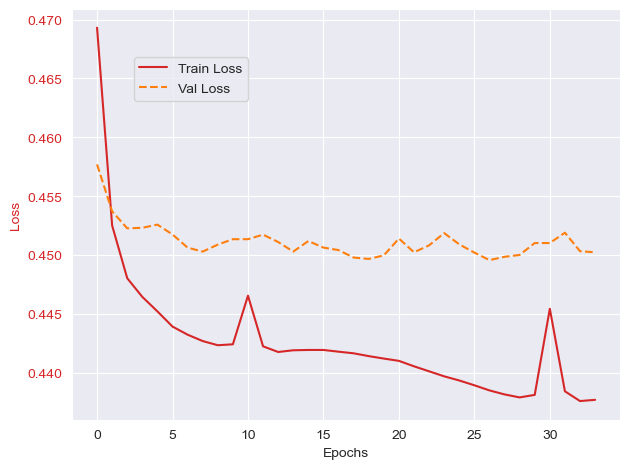

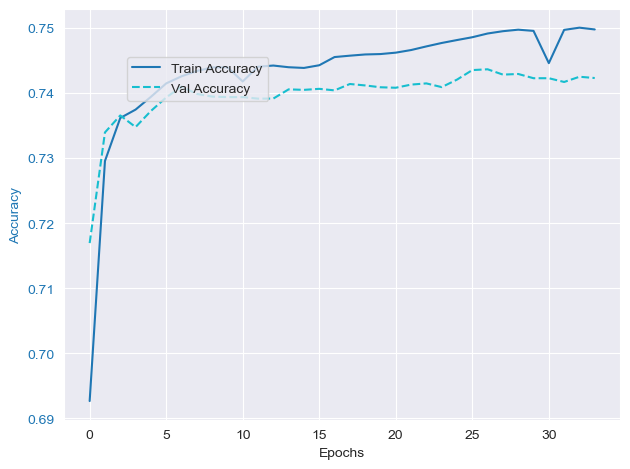

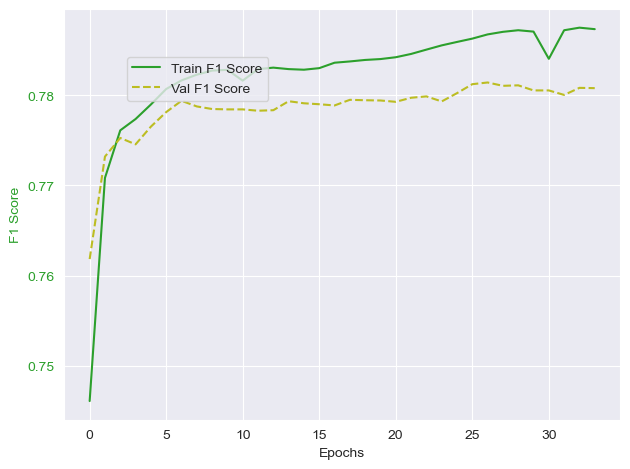

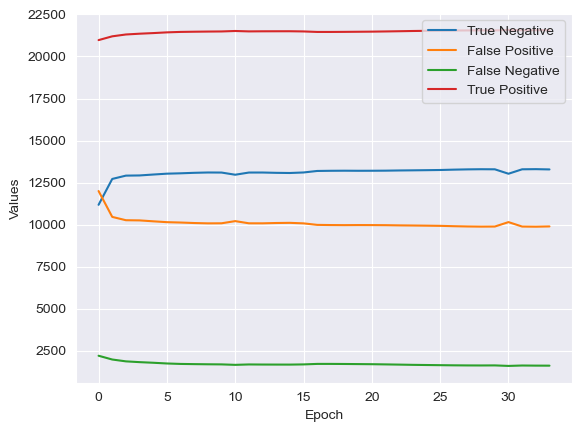

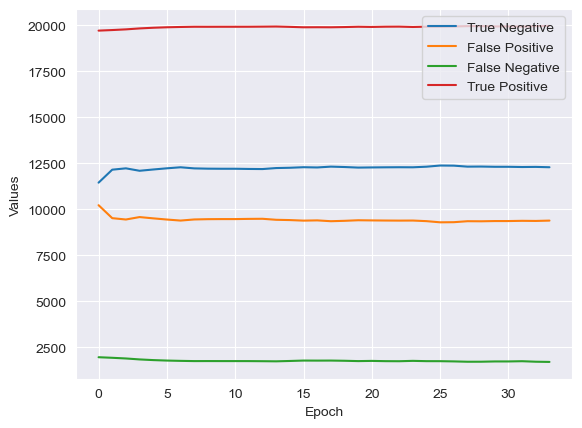

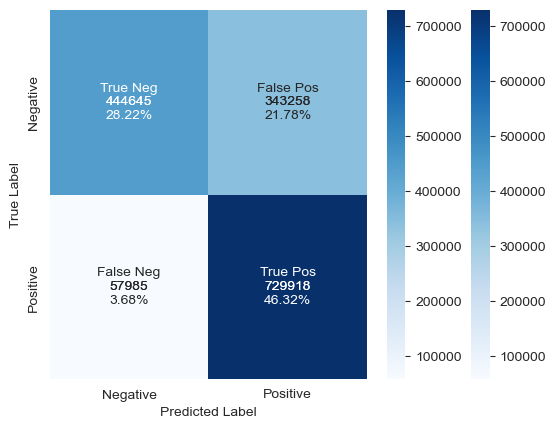

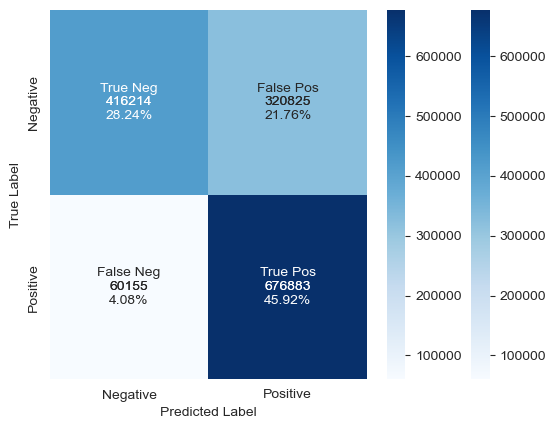

In [3]:
# def compute_loss(pos_score, neg_score, device=None):
#     scores = torch.cat([pos_score, neg_score])
#     labels = torch.cat(
#         [torch.ones(pos_score.shape[0], device=device), torch.zeros(neg_score.shape[0], device=device)]
#     ).double()
#     return F.binary_cross_entropy(scores, labels)


def compute_loss(pos_score, neg_score, device=None, loss_name='bce', pos_weight=None):
    """
    Computes loss based on the specified loss name.

    Args:
        pos_score (torch.Tensor): Positive class scores.
        neg_score (torch.Tensor): Negative class scores.
        device (torch.device, optional): Device for tensor operations.
        loss_name (str, optional): Type of loss function to compute ('bce', 'hinge', 'weighted_bce').
        class_weights (torch.Tensor, optional): Class weights for weighted BCE loss, expected as [weight_pos, weight_neg].

    Returns:
        torch.Tensor: Computed loss.
    """
    # Concatenate scores and labels
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0], device=device), torch.zeros(neg_score.shape[0], device=device)]
    ).double()

    if loss_name == 'bce':
        # Binary Cross Entropy Loss
        return F.binary_cross_entropy(scores, labels)

    elif loss_name == 'hinge':
        # Hinge Loss
        hinge_labels = 2 * labels - 1  # Convert labels to {-1, 1} for hinge loss
        return torch.mean(torch.clamp(1 - scores * hinge_labels, min=0))
    elif loss_name == 'weighted_bce':
        # Convert scores (probabilities) to logits
        logits = torch.log(scores / (1 - scores))  # Inverse of the sigmoid function

        return F.binary_cross_entropy_with_logits(logits, labels, pos_weight=pos_weight)
    else:
        raise ValueError(f"Unsupported loss_name: {loss_name}. Choose from 'bce', 'hinge', 'weighted_bce'.")


# Helper function to save figures
def save_figure(fig, save_path, save):
    if save:
        fig.savefig(save_path, format='pdf')


# Helper function to plot training and validation loss
def plot_loss(ax, train_loss, val_loss):
    color = 'tab:red'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss', color=color)
    ax.plot(train_loss, color=color, label='Train Loss')
    ax.plot(val_loss, color='tab:orange', linestyle='--', label='Val Loss')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


# Helper function to plot training and validation accuracy
def plot_accuracy(ax, train_acc, val_acc):
    color = 'tab:blue'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy', color=color)
    ax.plot(train_acc, color=color, label='Train Accuracy')
    ax.plot(val_acc, color='tab:cyan', linestyle='--', label='Val Accuracy')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


def plot_f1(ax, train_f1, val_f1):
    color = 'tab:green'
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score', color=color)
    ax.plot(train_f1, color=color, label='Train F1 Score')
    ax.plot(val_f1, color='tab:olive', linestyle='--', label='Val F1 Score')
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


# Line plot of the confusion matrix metrics over epochs
def plot_cm_metrics(ax, tn, fp, fn, tp):
    metrics = [tn, fp, fn, tp]
    for m_name, m_values in zip(['True Negative', 'False Positive', 'False Negative', 'True Positive'], metrics):
        ax.plot(range(m_values.shape[0]), m_values, label=m_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)


# Compute summed values for each confusion matrix metric
def plot_confusion_matrix(ax, tn, fp, fn, tp):
    summed_values = {
        'True Negative': tn.sum(),
        'False Positive': fp.sum(),
        'False Negative': fn.sum(),
        'True Positive': tp.sum()
    }

    # Create a confusion matrix from the summed values
    matrix = np.array([[summed_values['True Negative'], summed_values['False Positive']],
                       [summed_values['False Negative'], summed_values['True Positive']]])

    # convert matrix to integers
    matrix = matrix.astype(int)

    # Plot confusion matrix heatmap
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten() / np.sum(matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues')
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')




# --------------------------------------- Plotting Training Statistics ---------------------------------------------
print("Plotting Training Statistics...")
save = True
# Read the training statistics from the CSV file
train_stats = pd.read_csv('metrics.csv')

# Extract loss and accuracy per epoch for both training and validation
train_loss_per_epoch = train_stats['train_loss'].dropna().reset_index(drop=True)
train_acc_per_epoch = train_stats['train_accuracy'].dropna().reset_index(drop=True)

val_loss_per_epoch = train_stats['val_loss'].dropna().reset_index(drop=True)
val_acc_per_epoch = train_stats['val_accuracy'].dropna().reset_index(drop=True)

train_f1_per_epoch = train_stats['train_f1'].dropna().reset_index(drop=True)
val_f1_per_epoch = train_stats['val_f1'].dropna().reset_index(drop=True)

train_tn_per_epoch = train_stats['train_tn'].dropna().reset_index(drop=True)
train_fp_per_epoch = train_stats['train_fp'].dropna().reset_index(drop=True)
train_fn_per_epoch = train_stats['train_fn'].dropna().reset_index(drop=True)
train_tp_per_epoch = train_stats['train_tp'].dropna().reset_index(drop=True)

val_tn_per_epoch = train_stats['val_tn'].dropna().reset_index(drop=True)
val_fp_per_epoch = train_stats['val_fp'].dropna().reset_index(drop=True)
val_fn_per_epoch = train_stats['val_fn'].dropna().reset_index(drop=True)
val_tp_per_epoch = train_stats['val_tp'].dropna().reset_index(drop=True)

plot_types = ['one-for-all', 'acc-loss-f1-cm', 'train-val']
plot_type = plot_types[1]

if plot_type == 'one-for-all':
    fig, ax1 = plt.subplots()
    plot_loss(ax1, train_loss_per_epoch, val_loss_per_epoch)
    ax2 = ax1.twinx()
    plot_accuracy(ax2, train_acc_per_epoch, val_acc_per_epoch)
    ax3 = ax1.twinx()
    plot_f1(ax3, train_f1_per_epoch, val_f1_per_epoch)
    fig.tight_layout()

    #figure_savepath = f'figures/stgnn-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}.pdf'
    #save_figure(fig, figure_savepath, save)

elif plot_type == 'acc-loss-f1-cm':
    fig_loss, ax1 = plt.subplots()
    plot_loss(ax1, train_loss_per_epoch, val_loss_per_epoch)
    fig_loss.tight_layout()

    #loss_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-loss.pdf'
    #save_figure(fig_loss, loss_figure_savepath, save)

    fig_acc, ax2 = plt.subplots()
    plot_accuracy(ax2, train_acc_per_epoch, val_acc_per_epoch)
    fig_acc.tight_layout()

    #acc_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-accuracy.pdf'
    #save_figure(fig_acc, acc_figure_savepath, save)

    fig_f1, ax3 = plt.subplots()
    plot_f1(ax3, train_f1_per_epoch, val_f1_per_epoch)
    fig_f1.tight_layout()

    #f1_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-f1.pdf'
    #save_figure(fig_f1, f1_figure_savepath, save)

    fig_train_cm_metrics, ax4 = plt.subplots()
    plot_cm_metrics(ax4, train_tn_per_epoch, train_fp_per_epoch, train_fn_per_epoch, train_tp_per_epoch)

    #cm_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-train-cm-metrics.pdf'
    #save_figure(fig_train_cm_metrics, cm_figure_savepath, save)

    fig_val_cm_metrics, ax5 = plt.subplots()
    plot_cm_metrics(ax5, val_tn_per_epoch, val_fp_per_epoch, val_fn_per_epoch, val_tp_per_epoch)

    #cm_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-val-cm-metrics.pdf'
    #save_figure(fig_val_cm_metrics, cm_figure_savepath, save)

    fig_train_cm, ax6 = plt.subplots()
    plot_confusion_matrix(ax6, train_tn_per_epoch, train_fp_per_epoch, train_fn_per_epoch, train_tp_per_epoch)

    #cm_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-train-cm.pdf'
    #save_figure(fig_train_cm, cm_figure_savepath, save)

    fig_val_cm, ax7 = plt.subplots()
    plot_confusion_matrix(ax7, val_tn_per_epoch, val_fp_per_epoch, val_fn_per_epoch, val_tp_per_epoch)

    #cm_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-val-cm.pdf'
    #save_figure(fig_val_cm, cm_figure_savepath, save)

elif plot_type == 'train-val':
    # Plotting Training Statistics
    fig_train, ax1 = plt.subplots()

    # Plot training loss
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(train_loss_per_epoch, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for training accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Training Accuracy', color=color)
    ax2.plot(train_acc_per_epoch, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both y-axes
    fig_train.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    fig_train.tight_layout()

    # Save the training figure based on conditions
    #train_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-train.pdf'
    #save_figure(fig_train, train_figure_savepath, save)

    # Plotting Validation Statistics
    fig_val, ax3 = plt.subplots()

    # Plot validation loss
    color = 'tab:orange'
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Validation Loss', color=color)
    ax3.plot(val_loss_per_epoch, color=color, linestyle='--', label='Val Loss')
    ax3.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for validation accuracy
    ax4 = ax3.twinx()
    color = 'tab:cyan'
    ax4.set_ylabel('Validation Accuracy', color=color)
    ax4.plot(val_acc_per_epoch, color=color, linestyle='--', label='Val Accuracy')
    ax4.tick_params(axis='y', labelcolor=color)

    # Combine legends from both y-axes
    fig_val.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    fig_val.tight_layout()

    # Save the validation figure based on conditions
    #val_figure_savepath = f'figures/stgnn-{loss_name}-{time_module}-{time_layers}-{space_module}-{space_layers}-h-{hidden_size}-o-{output_size}-w-{window}-e-{max_epochs}-val.pdf'
    #save_figure(fig_val, val_figure_savepath, save)